In [2]:
import os
from collections import OrderedDict,Counter
from __future__ import division
import pandas as pd
import numpy as np
import vcf
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: license expired

    the package numpy 1.10.2 was published on 2015-12-14,
    however the mkl license expiration date is 2015-05-28.
    You may be able to run earlier versions of numpy using your
    current license.  A new license can be purchased at: http://continuum.io
    To revert to an earlier set of conda packages, use:
    $ conda list --revisions
    ...
    $ conda install --revision <REVISION NUMBER>

    


In [41]:
#get pop info
test = pd.read_csv('/home/lindb/wbp/WBP_IDS_MATCHED_POP_FINAL_02162016.csv',header=0,sep="\t")
test.head()

,ID,UCD_ID,Population_ID,Plot_id,pop_plot_m,Duplicate,tag_id,fam_id,lon,lat,...,ht_pop,bf_pop,rs_pop,c13_pop,n15_pop,ht_fam,bf_fam,rs_fam,c13_fam,n15_fam
0,028compiled,WBP0028,Dicks_Pass,3,Dicks_Pass3,NDUP,2180,DP100,-120.134729,38.911685,...,4.069880,116.365805,2.470894,-31.042967,21.668347,4.370406,117.503196,2.564821,-30.944199,21.744727
1,024compiled,WBP0024,Dicks_Pass,2,Dicks_Pass2,NDUP,1878,DP101,-120.130955,38.910358,...,4.188304,118.967882,2.589387,-31.007308,21.457787,4.434397,118.830903,2.625141,-30.932084,21.621277
2,020compiled,WBP0020,Dicks_Pass,2,Dicks_Pass2,NDUP,1893,DP102,-120.130955,38.910358,...,4.651279,108.185118,2.518880,-31.161449,19.862602,4.686165,113.339703,2.589155,-31.011809,20.797976
3,025compiled,WBP0025,Dicks_Pass,2,Dicks_Pass2,NDUP,1889,DP103,-120.130955,38.910358,...,4.507014,119.125510,2.474552,-30.724324,22.608675,4.622005,118.957183,2.557041,-30.779590,22.230761
4,023compiled,WBP0023,Dicks_Pass,2,Dicks_Pass2,NDUP,1901,DP104,-120.130955,38.910358,...,4.839617,118.849584,2.659597,-30.919382,24.572579,4.795414,118.811803,2.658050,-30.886640,23.240264


In [42]:
len(np.unique(test['UCD_ID']))

245

In [43]:
#get pop info
stpDict = OrderedDict()
for row in test.index:
    ID = test.loc[row,'UCD_ID'][-3:] + 'compiled'
    if ID not in stpDict.keys():
        stpDict[ID] = OrderedDict()
    stpDict[ID]['pop'] = test.loc[row,'Population_ID']
    stpDict[ID]['plot'] = str(test.loc[row,'Plot_id'])
len(stpDict.keys())    

245

In [41]:
#write out for future use
filE = '/home/lindb/wbp/sampsTOpop.txt'
with open(filE,'w') as o:
    text = '\t'.join(['sampID','pop','plot'])+'\n'
    o.write("%s" % text)
    for samp in sorted(stpDict.keys()):
        text = '\t'.join([samp,stpDict[samp]['pop'],stpDict[samp]['plot']])+'\n'
        o.write("%s" % text)
stp = pd.read_csv(filE,header=0,sep="\t")
stp.head()

,sampID,pop,plot
0,009compiled,Dicks_Pass,1
1,010compiled,Dicks_Pass,1
2,011compiled,Dicks_Pass,1
3,012compiled,Dicks_Pass,1
4,013compiled,Dicks_Pass,1


In [160]:
stp = pd.read_csv('/home/lindb/wbp/sampsTOpop.txt',header=0,sep="\t")
stp.head()

,sampID,pop,plot
0,028compiled,Dicks_Pass,3
1,024compiled,Dicks_Pass,2
2,020compiled,Dicks_Pass,2
3,025compiled,Dicks_Pass,2
4,023compiled,Dicks_Pass,2


In [161]:
stpDict = OrderedDict()
for row in stp.index:
    samp = stp.loc[row,'sampID']
    stpDict[samp] = OrderedDict()
    stpDict[samp]['pop'] = stp.loc[row,'pop']
    stpDict[samp]['plot'] = stp.loc[row,'plot']

In [157]:
#convert vcf.012 to data.frame
def get_z12_df(z12_file):
    indv_file = "%s.indv" % z12_file
    pos_file = "%s.pos" % z12_file
    z12_data = []
    for i, line in enumerate(open(z12_file)):
        line = line.strip()
        line = [int(x) for x in line.split("\t")]
        z12_data.append(np.array(line))
    z12_data = np.array(z12_data)
    p = pd.read_csv(pos_file, sep="\t", names=['contig', 'pos'])
    df = pd.DataFrame(z12_data)
    df = df.drop(0, axis=1)
    df.columns = p.apply(lambda x: "%s_%s" % (x.contig, x.pos), axis=1)
    df.index = [x.strip() for x in open(indv_file).readlines()]    
    return df

In [155]:
misdir = '/home/lindb/wbp/concatenated/snps/'
impdir = '/home/lindb/wbp/concatenated/snps/beagle40/'
misz12 = os.path.join(misdir,'isect_one_per_contig.recode.vcf.gz_sorted.vcf.gz.012')
impz12 = os.path.join(impdir,'isect_one_per_contig.recode.vcf.gz_sorted.vcf.gz.012')
z12s = [impz12,misz12]

In [158]:
z12_dfs = [get_z12_df(z) for z in z12s]

In [10]:
z12_dfs[0][z12_dfs[0].columns[-3:]].head()

,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
153compiled,0,0,1
046compiled,0,0,1
096compiled,0,0,1
023compiled,0,0,1
213compiled,0,0,1


In [159]:
z12_dfs[1][z12_dfs[1].columns[-3:]].head()

,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
153compiled,-1,0,-1
046compiled,-1,-1,1
096compiled,0,-1,1
023compiled,-1,0,-1
213compiled,-1,-1,-1


In [11]:
'249compiled' in z12_dfs[0].index

True

In [12]:
[z.shape for z in z12_dfs]

[(244, 116231), (244, 116231)]

In [162]:
for z in z12_dfs:
    for samp in z.index:
        z.loc[samp,'population'] = stpDict[samp]['pop']
        #print samp,stpDict[samp]

In [258]:
z12_dfs[0].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population
153compiled,1,2,0,0,0,0,0,0,1,2,...,0,1,0,1,0,0,0,0,1,Snow_Valley_Peak
046compiled,0,0,1,0,1,0,0,0,1,2,...,0,1,0,1,1,0,0,0,1,Heavenly
096compiled,0,0,0,0,0,1,1,0,1,2,...,0,0,0,2,0,0,0,0,1,Freel_Peak
023compiled,0,1,0,0,0,0,1,0,2,1,...,0,1,0,2,1,0,0,0,1,Dicks_Pass
213compiled,0,0,0,0,0,0,1,0,1,2,...,0,0,0,1,1,0,0,0,1,Mt_Rose_Ophir


In [163]:
z12_dfs[0][z12_dfs[0].columns[-3:]].head()

,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population
153compiled,0,1,Snow_Valley_Peak
046compiled,0,1,Heavenly
096compiled,0,1,Freel_Peak
023compiled,0,1,Dicks_Pass
213compiled,0,1,Mt_Rose_Ophir


In [164]:
z12_dfs[1][z12_dfs[1].columns[-3:]].head()

,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population
153compiled,0,-1,Snow_Valley_Peak
046compiled,-1,1,Heavenly
096compiled,-1,1,Freel_Peak
023compiled,0,-1,Dicks_Pass
213compiled,-1,-1,Mt_Rose_Ophir


In [15]:
[z.shape for z in z12_dfs]

[(244, 116232), (244, 116232)]

In [16]:
def get_percent_missing(col):
    return len(col[col==-1])*1.0/len(col)   

In [71]:
%time p_mis = z12_dfs[1].apply(get_percent_missing,axis=0)

CPU times: user 1min 2s, sys: 162 ms, total: 1min 2s
Wall time: 1min 2s


In [72]:
p_mis.describe()
#count    116232.000000
#mean          0.350268
#std           0.090316
#min           0.000000
#25%           0.282787
#50%           0.356557
#75%           0.426230
#max           0.500000
#dtype: float64

count    116232.000000
mean          0.350268
std           0.090316
min           0.000000
25%           0.282787
50%           0.356557
75%           0.426230
max           0.500000
dtype: float64

In [73]:
%time p_imp = z12_dfs[0].apply(get_percent_missing,axis=0)

CPU times: user 1min 2s, sys: 175 ms, total: 1min 2s
Wall time: 1min 2s


In [74]:
p_imp.describe() #should be 0 since it's the imputed set
#count    116232
#mean          0
#std           0
#min           0
#25%           0
#50%           0
#75%           0
#max           0
#dtype: float64

count    116232
mean          0
std           0
min           0
25%           0
50%           0
75%           0
max           0
dtype: float64

In [114]:
flz = ['/home/lindb/wbp/workingsnps/imputed/imputed_z12.txt','/home/lindb/wbp/workingsnps/missing/missing_z12.txt']
for i,z in enumerate(z12_dfs):
    z.to_csv(flz[i],header=True,index=True,sep="\t")

In [254]:
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def get_allele_freqs(locus, debug):
    c = locus[locus != -1].value_counts()
    total_alleles = 2.0*sum(c)
    num_individuals = sum(c)
    P = 0
    Q = 0
    PQ = 0
    if 0 in c:
        P = 2*c[0]
    if 2 in c:
        Q = 2*c[2]
    if 1 in c:
        PQ = c[1]
    P += PQ
    Q += PQ
    if total_alleles == 0:
        return None
    p = P/total_alleles
    q = Q/total_alleles
    assert p + q == 1.0
    He = 2 * p * q * get_correction(num_individuals)
    Ho = PQ*1.0/num_individuals
    Fis = 1 - (Ho/He)
    #print p, q, He, Ho, Fis
    
        
    ret = pd.Series({"p":p, 
                      "q":q,
                      "P":P,
                      "Q":Q,
                      "He":He,
                      "Ho":Ho, 
                      "Fis":Fis})
    if debug:
        print(ret)
    return ret

In [255]:
z12_freqs = [z.ix[:,:-1].apply(get_allele_freqs,debug=False) for z in z12_dfs]

In [256]:
[z.shape for z in z12_freqs]

[(7, 116231), (7, 116231)]

In [257]:
z12_freqs[0].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
Fis,0.403540,0.236976,-0.024065,-0.040598,-0.023109,-0.008282,-0.361535,-0.025263,-0.209405,-0.016701,...,-0.061002,-0.049569,-0.398830,-0.023109,-0.358195,0.338056,-0.049569,0.149345,-0.056399,-0.270895
He,0.213005,0.257818,0.216111,0.078769,0.048069,0.020323,0.448505,0.051966,0.420204,0.036279,...,0.112019,0.093715,0.474636,0.048069,0.470731,0.365293,0.093715,0.115629,0.104748,0.464369
Ho,0.127049,0.196721,0.221311,0.081967,0.049180,0.020492,0.610656,0.053279,0.508197,0.036885,...,0.118852,0.098361,0.663934,0.049180,0.639344,0.241803,0.098361,0.098361,0.110656,0.590164
P,429.000000,414.000000,428.000000,468.000000,476.000000,483.000000,323.000000,475.000000,146.000000,9.000000,...,459.000000,464.000000,188.000000,476.000000,184.000000,371.000000,464.000000,458.000000,461.000000,178.000000
Q,59.000000,74.000000,60.000000,20.000000,12.000000,5.000000,165.000000,13.000000,342.000000,479.000000,...,29.000000,24.000000,300.000000,12.000000,304.000000,117.000000,24.000000,30.000000,27.000000,310.000000


In [21]:
mafs = [z.apply(lambda x: min(x["p"], x["q"])) for z in z12_freqs]

In [22]:
mafs[0].head()

NODE_1000013_length_91_cov_1.802198_37     0.120902
NODE_1000031_length_98_cov_2.000000_30     0.151639
NODE_1000037_length_93_cov_2.043011_33     0.122951
NODE_1000042_length_93_cov_1.118280_100    0.040984
NODE_1000053_length_94_cov_1.744681_25     0.024590
dtype: float64

In [23]:
mafs[1].head()

NODE_1000013_length_91_cov_1.802198_37     0.180473
NODE_1000031_length_98_cov_2.000000_30     0.138710
NODE_1000037_length_93_cov_2.043011_33     0.145833
NODE_1000042_length_93_cov_1.118280_100    0.089147
NODE_1000053_length_94_cov_1.744681_25     0.027094
dtype: float64

In [24]:
min(mafs[0].tolist()),max(mafs[0].tolist())

(0.010245901639344262, 0.5)

In [25]:
min(mafs[1].tolist()),max(mafs[1].tolist())

(0.01, 0.5)

In [26]:
flz = ['/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf.txt','/home/lindb/wbp/workingsnps/missing/missing_z12_maf.txt']
for i,z in enumerate(mafs):
    print i
    m = pd.DataFrame(z)
    m.to_csv(flz[i],header=False,index=True,sep="\t")

0
1


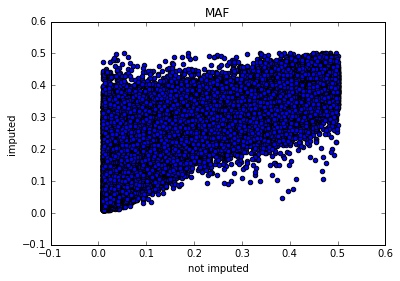

In [27]:
plt.scatter(mafs[0], mafs[1])
plt.title("MAF")
plt.xlabel("not imputed")
plt.ylabel("imputed")
plt.show()

In [28]:
#swap for minor allele
def swap_alleles(locus, af):
    if "_" in locus.name:
        locus_id = locus.name
        freqs = af[locus_id]
        maf = min(freqs["p"], freqs["q"])
        if maf == freqs["p"]:
            return locus.replace({0:2,2:0})
        return locus
    else:
        return locus

In [29]:
z12_swapped = []
for i, z in enumerate(z12_dfs):
    print i
    z12_swapped.append(z.apply(swap_alleles, args=(z12_freqs[i],)))

0
1


In [31]:
z12_dfs[0].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population
153compiled,1,2,0,0,0,0,0,0,1,2,...,0,1,0,1,0,0,0,0,1,Snow_Valley_Peak
046compiled,0,0,1,0,1,0,0,0,1,2,...,0,1,0,1,1,0,0,0,1,Heavenly
096compiled,0,0,0,0,0,1,1,0,1,2,...,0,0,0,2,0,0,0,0,1,Freel_Peak
023compiled,0,1,0,0,0,0,1,0,2,1,...,0,1,0,2,1,0,0,0,1,Dicks_Pass
213compiled,0,0,0,0,0,0,1,0,1,2,...,0,0,0,1,1,0,0,0,1,Mt_Rose_Ophir


In [30]:
z12_swapped[0].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population
153compiled,1,2,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,Snow_Valley_Peak
046compiled,0,0,1,0,1,0,0,0,1,0,...,0,1,0,1,1,0,0,0,1,Heavenly
096compiled,0,0,0,0,0,1,1,0,1,0,...,0,2,0,0,0,0,0,0,1,Freel_Peak
023compiled,0,1,0,0,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,Dicks_Pass
213compiled,0,0,0,0,0,0,1,0,1,0,...,0,2,0,1,1,0,0,0,1,Mt_Rose_Ophir


In [33]:
swaps = ['/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp.txt','/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp.txt']
for i,z in enumerate(z12_swapped):
    print i
    z12_swapped[i].to_csv(swaps[i],header=True,index=True,sep="\t")

0
1


In [167]:
swaps = ['/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp.txt','/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp.txt']
z12_swapped = []
for i,s in enumerate(swaps):
    z12_swapped.append(pd.read_csv(s,header=0,index_col=0,sep="\t"))

In [168]:
z12_swapped[0].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population
153compiled,1,2,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,Snow_Valley_Peak
046compiled,0,0,1,0,1,0,0,0,1,0,...,0,1,0,1,1,0,0,0,1,Heavenly
096compiled,0,0,0,0,0,1,1,0,1,0,...,0,2,0,0,0,0,0,0,1,Freel_Peak
023compiled,0,1,0,0,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,Dicks_Pass
213compiled,0,0,0,0,0,0,1,0,1,0,...,0,2,0,1,1,0,0,0,1,Mt_Rose_Ophir


In [169]:
z12_swapped[1].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population
153compiled,1,0,0,-1,0,0,0,0,1,1,...,0,1,0,1,0,1,-1,0,-1,Snow_Valley_Peak
046compiled,0,0,1,0,1,-1,-1,0,-1,0,...,0,0,0,-1,1,0,-1,-1,1,Heavenly
096compiled,0,0,0,-1,-1,1,1,0,-1,0,...,0,-1,-1,-1,-1,-1,0,-1,1,Freel_Peak
023compiled,-1,0,0,-1,0,0,-1,-1,-1,1,...,-1,-1,-1,0,0,0,-1,0,-1,Dicks_Pass
213compiled,-1,-1,-1,-1,-1,-1,-1,-1,1,0,...,-1,-1,-1,-1,1,-1,-1,-1,-1,Mt_Rose_Ophir


In [170]:
#while i'm at this point, might as well make files for hierfstat
hierf_trans = {0:'11', 1:'12', 2:'22', -1:'NA'}
def apply_hierf_trans(series):
    return [hierf_trans[x] for x in series]

In [172]:
#while i'm at this point, might as well make files for hierfstat
%time ztrans = [z.ix[:,:-1].apply(apply_hierf_trans) for z in z12_swapped]

CPU times: user 1min 48s, sys: 764 ms, total: 1min 49s
Wall time: 1min 48s


In [225]:
len(ztrans[0].columns)

116231

In [173]:
np.unique(ztrans[1][ztrans[1].columns[0]]) #missing

array(['11', '12', '22', 'NA'], dtype=object)

In [174]:
np.unique(ztrans[0][ztrans[0].columns[0]]) #imputed should not have "NA"

array(['11', '12', '22'], dtype=object)

In [175]:
pops = sorted(np.unique(z12_swapped[0]['population']))
pops

['Dicks_Pass',
 'Freel_Peak',
 'Heavenly',
 'Little_Round_Top',
 'Mt_Rose_Ophir',
 'Rifle_Peak',
 'Snow_Valley_Peak',
 'West_Shore_Peaks']

In [20]:
pops = ['Dicks_Pass',
 'Freel_Peak',
 'Heavenly',
 'Little_Round_Top',
 'Mt_Rose_Ophir',
 'Rifle_Peak',
 'Snow_Valley_Peak',
 'West_Shore_Peaks']

In [21]:
popids = OrderedDict()
for i,pop in enumerate(pops):
    i+=1
    popids[pop] = i
    print pop,i

Dicks_Pass 1
Freel_Peak 2
Heavenly 3
Little_Round_Top 4
Mt_Rose_Ophir 5
Rifle_Peak 6
Snow_Valley_Peak 7
West_Shore_Peaks 8


In [190]:
stpDict[stpDict.keys()[0]]

OrderedDict([('pop', 'Dicks_Pass'), ('plot', '3')])

In [178]:
ztrans[0].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
153compiled,12,22,11,11,11,11,11,11,12,11,...,11,11,12,11,12,11,11,11,11,12
046compiled,11,11,12,11,12,11,11,11,12,11,...,11,11,12,11,12,12,11,11,11,12
096compiled,11,11,11,11,11,12,12,11,12,11,...,11,11,22,11,11,11,11,11,11,12
023compiled,11,12,11,11,11,11,12,11,11,12,...,11,11,12,11,11,12,11,11,11,12
213compiled,11,11,11,11,11,11,12,11,12,11,...,11,11,22,11,12,12,11,11,11,12


In [179]:
ztrans[1].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
153compiled,12,11,11,NA,11,11,11,11,12,12,...,NA,11,12,11,12,11,12,NA,11,NA
046compiled,11,11,12,11,12,NA,NA,11,NA,11,...,11,11,11,11,NA,12,11,NA,NA,12
096compiled,11,11,11,NA,NA,12,12,11,NA,11,...,11,11,NA,NA,NA,NA,NA,11,NA,12
023compiled,NA,11,11,NA,11,11,NA,NA,NA,12,...,NA,NA,NA,NA,11,11,11,NA,11,NA
213compiled,NA,NA,NA,NA,NA,NA,NA,NA,12,11,...,NA,NA,NA,NA,NA,12,NA,NA,NA,NA


In [181]:
#while i'm at this point, might as well make files for hierfstat
for z in ztrans:
    for samp in z.index:
        z.loc[samp,'popid']  = popids[stpDict[samp]['pop']]
        z.loc[samp,'plotid'] = stpDict[samp]['plot']

In [182]:
ztrans[0][ztrans[0].columns[-3:]].head()

,NODE_999969_length_92_cov_4.271739_37,popid,plotid
153compiled,12,7,1
046compiled,12,3,2
096compiled,12,2,3
023compiled,12,1,2
213compiled,12,5,1


In [183]:
ztrans[1][ztrans[1].columns[-3:]].head()

,NODE_999969_length_92_cov_4.271739_37,popid,plotid
153compiled,NA,7,1
046compiled,12,3,2
096compiled,12,2,3
023compiled,NA,1,2
213compiled,NA,5,1


In [193]:
ztrans[0].columns[-10:-2]

Index([u'NODE_999899_length_96_cov_1.000000_91',
       u'NODE_999927_length_95_cov_2.000000_55',
       u'NODE_999933_length_76_cov_1.236842_76',
       u'NODE_999938_length_98_cov_1.142857_98',
       u'NODE_999941_length_107_cov_1.196262_25',
       u'NODE_999958_length_91_cov_1.021978_17',
       u'NODE_999968_length_75_cov_1.680000_37',
       u'NODE_999969_length_92_cov_4.271739_37'],
      dtype='object')

In [184]:
#this was executed
for i,z in enumerate(ztrans):
    z.sort_index(inplace=True)

In [185]:
cols = [['popid','plotid'],['popid','plotid']]
for i,z in enumerate(ztrans):
    cols[i].extend([c for c in z.columns[:-2]])
    ztrans[i] = ztrans[i][[x for x in cols[i]]]

In [238]:
len(cols[0])

116233

In [186]:
ztrans[0].head()

,popid,plotid,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,1,1,11,12,11,11,11,11,12,11,...,11,11,12,11,12,12,11,11,11,12
010compiled,1,1,11,12,12,11,11,11,11,11,...,11,11,11,11,12,12,11,11,11,11
011compiled,1,1,12,11,12,11,11,11,12,11,...,11,11,12,11,12,11,11,11,11,11
012compiled,1,1,11,11,11,12,11,11,12,11,...,11,12,22,11,12,11,11,11,12,12
013compiled,1,1,22,11,11,11,11,11,12,12,...,11,11,12,11,12,11,11,11,11,12


In [187]:
ztrans[1].head()

,popid,plotid,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,1,1,11,NA,11,11,11,11,12,11,...,11,11,NA,11,12,12,11,11,11,NA
010compiled,1,1,11,12,12,11,11,11,11,11,...,11,11,11,11,12,12,11,11,11,11
011compiled,1,1,12,11,12,11,11,11,12,11,...,11,11,12,11,NA,11,11,11,11,11
012compiled,1,1,11,11,11,12,11,11,12,11,...,11,12,22,11,12,11,11,11,12,12
013compiled,1,1,22,12,11,12,11,11,12,11,...,11,11,12,11,NA,11,12,11,11,12


In [189]:
fs = ['/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans.txt',
      '/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans.txt']
for i,z in enumerate(ztrans):
    print i,fs[i]

0 /home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans.txt
1 /home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans.txt


In [242]:
#while i'm at this point, might as well make files for hierfstat
fs = ['/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans.txt',
      '/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans.txt']
for i,z in enumerate(ztrans):
    print i
    z.to_csv(fs[i],header=True,index=True,sep="\t")

0
1


In [197]:
fs = ['/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans.txt',
      '/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans.txt']
ztrans = OrderedDict()
for i,f in enumerate(fs):
    ztrans[dset[i]] = pd.read_csv(f,header=0,index_col=0,sep="\t")  

In [198]:
ztrans.keys()

['imp', 'mis']

In [211]:
ztrans['mis'].fillna("NA",inplace=True)
ztrans['mis'].replace([11,12,22],['11','12','22'],inplace=True)
ztrans['mis'].head()

,popid,plotid,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,1,1,11,NA,11,11,11,11,12,11,...,11,11,NA,11,12,12,11,11,11,NA
010compiled,1,1,11,12,12,11,11,11,11,11,...,11,11,11,11,12,12,11,11,11,11
011compiled,1,1,12,11,12,11,11,11,12,11,...,11,11,12,11,NA,11,11,11,11,11
012compiled,1,1,11,11,11,12,11,11,12,11,...,11,12,22,11,12,11,11,11,12,12
013compiled,1,1,22,12,11,12,11,11,12,11,...,11,11,12,11,NA,11,12,11,11,12


In [230]:
ztrans['imp'].replace([11,12,22],['11','12','22'],inplace=True)
ztrans['imp'].head()

,popid,plotid,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,1,1,11,12,11,11,11,11,12,11,...,11,11,12,11,12,12,11,11,11,12
010compiled,1,1,11,12,12,11,11,11,11,11,...,11,11,11,11,12,12,11,11,11,11
011compiled,1,1,12,11,12,11,11,11,12,11,...,11,11,12,11,12,11,11,11,11,11
012compiled,1,1,11,11,11,12,11,11,12,11,...,11,12,22,11,12,11,11,11,12,12
013compiled,1,1,22,11,11,11,11,11,12,12,...,11,11,12,11,12,11,11,11,11,12


In [215]:
#rewrite just in case
fs = ['/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans.txt',
      '/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans.txt']
for i,f in enumerate(fs):
    ztrans[dset[i]].to_csv(f,header=True,index=True,sep="\t")

In [231]:
ztrans['imp'].to_csv('/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans.txt',header=True,index=True,sep="\t")

In [232]:
np.unique(ztrans['imp'][ztrans['imp'].columns[3]])

array(['11', '12', '22'], dtype=object)

In [217]:
np.unique(ztrans['mis'][ztrans['mis'].columns[10]]) #missing should have "NAs"

array(['11', '12', '22', 'NA'], dtype=object)

In [218]:
#get back to -1,0,1,2 from hierfstat_trans
z12_trans = {'NA':-1, '11':0, '12':1, '22':2}
def convert_to_z12(col):
    return [z12_trans[x] for x in col]

In [258]:
z12_trans[ztrans['mis'].loc['009compiled','NODE_1000013_length_91_cov_1.802198_37']]

0

In [219]:
hierf_z12 = OrderedDict()
%time hierf_z12['mis'] = ztrans['mis'].ix[:,2:].apply(convert_to_z12)

CPU times: user 31.5 s, sys: 129 ms, total: 31.6 s
Wall time: 31.6 s


In [222]:
hierf_z12['mis'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,0,-1,0,0,0,0,1,0,-1,0,...,0,0,-1,0,1,1,0,0,0,-1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
011compiled,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,-1,0,0,0,0,0
012compiled,0,0,0,1,0,0,1,0,1,0,...,0,1,2,0,1,0,0,0,1,1
013compiled,2,1,0,1,0,0,1,0,1,0,...,0,0,1,0,-1,0,1,0,0,1


In [233]:
%time hierf_z12['imp'] = ztrans['imp'].ix[:,2:].apply(convert_to_z12)

CPU times: user 32.1 s, sys: 154 ms, total: 32.3 s
Wall time: 32.2 s


In [234]:
for dset in hierf_z12.keys():
    print hierf_z12[dset].shape

(244, 116231)
(244, 116231)


In [235]:
np.unique(hierf_z12['mis'][hierf_z12['mis'].columns[0]]) #should be -1 in missing

array([-1,  0,  1,  2])

In [236]:
np.unique(hierf_z12['imp'][hierf_z12['imp'].columns[0]])

array([0, 1, 2])

In [237]:
hierf_z12['imp'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,1,1,0,0,0,1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
011compiled,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
012compiled,0,0,0,1,0,0,1,0,1,0,...,0,1,2,0,1,0,0,0,1,1
013compiled,2,0,0,0,0,0,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1


In [238]:
fs = OrderedDict()
fs['imp'] = '/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans_z12.txt'
fs['mis'] = '/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans_z12.txt'
for dset in hierf_z12:
    print dset
    hierf_z12[dset].to_csv(fs[dset],header=True,index=True,sep="\t")

mis
imp


In [151]:
fs = OrderedDict()
fs['imp'] = '/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans_z12.txt'
fs['mis'] = '/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans_z12.txt'
hierf_z12 = OrderedDict()
for dset in fs.keys():
    hierf_z12[dset] = pd.read_csv(fs[dset],header=0,index_col=0,sep="\t")

In [239]:
hierf_z12['imp'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,1,1,0,0,0,1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
011compiled,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
012compiled,0,0,0,1,0,0,1,0,1,0,...,0,1,2,0,1,0,0,0,1,1
013compiled,2,0,0,0,0,0,1,1,1,0,...,0,0,1,0,1,0,0,0,0,1


In [240]:
hierf_z12['mis'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,0,-1,0,0,0,0,1,0,-1,0,...,0,0,-1,0,1,1,0,0,0,-1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
011compiled,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,-1,0,0,0,0,0
012compiled,0,0,0,1,0,0,1,0,1,0,...,0,1,2,0,1,0,0,0,1,1
013compiled,2,1,0,1,0,0,1,0,1,0,...,0,0,1,0,-1,0,1,0,0,1


# now the actual PCA

In [244]:
popids

OrderedDict([('Dicks_Pass', 1),
             ('Freel_Peak', 2),
             ('Heavenly', 3),
             ('Little_Round_Top', 4),
             ('Mt_Rose_Ophir', 5),
             ('Rifle_Peak', 6),
             ('Snow_Valley_Peak', 7),
             ('West_Shore_Peaks', 8)])

In [245]:
for dset in hierf_z12:
    for samp in hierf_z12[dset].index:
        hierf_z12[dset].loc[samp,'population'] = popids[stpDict[samp]['pop']]
        hierf_z12[dset].loc[samp,'plot'] = stpDict[samp]['plot']

In [246]:
'plot' in hierf_z12['imp'].columns

True

In [249]:
'plot' in hierf_z12['mis'].columns

True

In [261]:
hierf_z12['imp'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population,plot
009compiled,0,1,0,0,0,0,1,0,1,0,...,1,0,1,1,0,0,0,1,1,1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,1
011compiled,1,0,1,0,0,0,1,0,1,0,...,1,0,1,0,0,0,0,0,1,1
012compiled,0,0,0,1,0,0,1,0,1,0,...,2,0,1,0,0,0,1,1,1,1
013compiled,2,0,0,0,0,0,1,1,1,0,...,1,0,1,0,0,0,0,1,1,1


In [270]:
hierf_z12['mis'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population,plot
009compiled,0,-1,0,0,0,0,1,0,-1,0,...,-1,0,1,1,0,0,0,-1,1,1
010compiled,0,1,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,1
011compiled,1,0,1,0,0,0,1,0,1,0,...,1,0,-1,0,0,0,0,0,1,1
012compiled,0,0,0,1,0,0,1,0,1,0,...,2,0,1,0,0,0,1,1,1,1
013compiled,2,1,0,1,0,0,1,0,1,0,...,1,0,-1,0,1,0,0,1,1,1


In [266]:
def center_and_standardize_value(val, u, var):
    if val == -1:
        return 0.0
    return (val-u)/np.sqrt(var)

def center_and_standardize(locus, af):
    if "NODE" in locus.name:
        #locus_id = int(locus.name[1:])
        locus_id = locus.name
        freqs = af[locus_id]
        maf = min(freqs["p"], freqs["q"])
        var = maf*(1-maf)
        u = np.mean([x for x in locus if x != -1])
        return locus.apply(center_and_standardize_value, args=(u, var))
    return locus

In [263]:
temp_freqs = z12_freqs

In [264]:
z12_freqs = OrderedDict()
z12_freqs['imp'] = temp_freqs[0]
z12_freqs['mis'] = temp_freqs[1]

In [273]:
pca_std = OrderedDict()
%time
for dset in hierf_z12.keys():
    pca_std[dset] = hierf_z12[dset].apply(center_and_standardize, args=(z12_freqs[dset],))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 24.8 µs


In [274]:
hierf_z12.keys()

['mis', 'imp']

In [275]:
%time
fs = OrderedDict()
fs['imp'] = '/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans_z12_pca_std.txt'
fs['mis'] = '/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans_z12_pca_std.txt'
for i,dset in enumerate(pca_std.keys()):
    pca_std[dset].to_csv(fs[dset],header=True,index=True,sep="\t")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


In [276]:
%time
pca_std = OrderedDict()
dsets = ['imp','mis']
for i,dset in enumerate(dsets):
    pca_std[dset] = pd.read_csv(fs[dset],header=0,index_col=0,sep="\t")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.2 µs


In [277]:
pca_std['mis'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population,plot
009compiled,-0.938545,0.000000,-0.826394,-0.625691,-0.333755,-0.254411,0.840683,-0.406838,0.000000,-0.551781,...,0.000000,-0.37858,0.3698,1.259859,-0.669150,-0.692007,-0.661438,0.000000,1,1
010compiled,-0.938545,2.090538,2.006957,-0.625691,-0.333755,-0.254411,-1.328821,-0.406838,-1.394322,-0.551781,...,-1.255843,-0.37858,0.3698,1.259859,-0.669150,-0.692007,-0.661438,-1.546459,1,1
011compiled,1.661686,-0.802617,2.006957,-0.625691,-0.333755,-0.254411,0.840683,-0.406838,0.737228,-0.551781,...,0.964633,-0.37858,0.0000,-1.103876,-0.669150,-0.692007,-0.661438,-1.546459,1,1
012compiled,-0.938545,-0.802617,-0.826394,2.883620,-0.333755,-0.254411,0.840683,-0.406838,0.737228,-0.551781,...,3.185110,-0.37858,0.3698,-1.103876,-0.669150,-0.692007,2.692997,0.520048,1,1
013compiled,4.261917,2.090538,-0.826394,2.883620,-0.333755,-0.254411,0.840683,-0.406838,0.737228,-0.551781,...,0.964633,-0.37858,0.0000,-1.103876,2.654293,-0.692007,-0.661438,0.520048,1,1


In [278]:
pca_std['imp'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population,plot
009compiled,-0.741698,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,0.471605,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,0.561931,1,1
010compiled,-0.741698,1.942508,2.296415,-0.413449,-0.317554,-0.203489,-1.429456,-0.330868,-1.306753,-0.274147,...,-1.583246,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,-1.515511,1,1
011compiled,2.325665,-0.845562,2.296415,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,-1.515511,1,1
012compiled,-0.741698,-0.845562,-0.748831,4.630630,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,2.526456,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,3.890070,0.561931,1,1
013compiled,5.393028,-0.845562,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,5.879271,0.877135,-0.274147,...,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,0.561931,1,1


In [280]:
len(pca_std['mis'].columns)

116233

In [281]:
len(pca_std['imp'].columns)

116233

In [282]:
pca_std.keys()

['imp', 'mis']

In [283]:
pca_std_data = OrderedDict()
for dset in pca_std.keys():
    cols = [col for col in pca_std[dset].columns if 'NODE' in col]
    pca_std_data[dset] = pca_std[dset].ix[:,[col for col in cols]]

In [284]:
pca_std_data['imp'].shape

(244, 116231)

In [285]:
pca_std_data['imp'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,-0.741698,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-0.502716,-0.454859,0.471605,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,0.561931
010compiled,-0.741698,1.942508,2.296415,-0.413449,-0.317554,-0.203489,-1.429456,-0.330868,-1.306753,-0.274147,...,-0.502716,-0.454859,-1.583246,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,-1.515511
011compiled,2.325665,-0.845562,2.296415,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-0.502716,-0.454859,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,-1.515511
012compiled,-0.741698,-0.845562,-0.748831,4.630630,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-0.502716,4.169539,2.526456,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,3.890070,0.561931
013compiled,5.393028,-0.845562,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,5.879271,0.877135,-0.274147,...,-0.502716,-0.454859,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,0.561931


In [286]:
pca_std_data['mis'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,-0.938545,0.000000,-0.826394,-0.625691,-0.333755,-0.254411,0.840683,-0.406838,0.000000,-0.551781,...,-0.597234,-0.549442,0.000000,-0.37858,0.3698,1.259859,-0.669150,-0.692007,-0.661438,0.000000
010compiled,-0.938545,2.090538,2.006957,-0.625691,-0.333755,-0.254411,-1.328821,-0.406838,-1.394322,-0.551781,...,-0.597234,-0.549442,-1.255843,-0.37858,0.3698,1.259859,-0.669150,-0.692007,-0.661438,-1.546459
011compiled,1.661686,-0.802617,2.006957,-0.625691,-0.333755,-0.254411,0.840683,-0.406838,0.737228,-0.551781,...,-0.597234,-0.549442,0.964633,-0.37858,0.0000,-1.103876,-0.669150,-0.692007,-0.661438,-1.546459
012compiled,-0.938545,-0.802617,-0.826394,2.883620,-0.333755,-0.254411,0.840683,-0.406838,0.737228,-0.551781,...,-0.597234,3.365334,3.185110,-0.37858,0.3698,-1.103876,-0.669150,-0.692007,2.692997,0.520048
013compiled,4.261917,2.090538,-0.826394,2.883620,-0.333755,-0.254411,0.840683,-0.406838,0.737228,-0.551781,...,-0.597234,-0.549442,0.964633,-0.37858,0.0000,-1.103876,2.654293,-0.692007,-0.661438,0.520048


In [287]:
len(pca_std_data['imp'].columns)

116231

In [288]:
fs = OrderedDict()
fs['imp'] = '/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans_z12_pca_std.txt'
fs['mis'] = '/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans_z12_pca_std.txt'
for i,dset in enumerate(pca_std_data.keys()):
    pca_std_data[dset].to_csv(fs[dset],header=True,index=True,sep="\t")

In [289]:
pca_std_data.keys()

['imp', 'mis']

## R magic voodoo

In [3]:
def setup_r(): 
    os.environ['R_HOME'] = '/home/lindb/g/R3/lib64/R/' 
    os.environ['LD_LIBRARY_PATH'] = "%s/lib:%s" % (os.environ['R_HOME'], 
                                                   os.environ['LD_LIBRARY_PATH'])

In [4]:
setup_r()
import readline
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri as pd2ri
pd2ri.activate()
r = robjects.r

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython
%matplotlib inline

In [6]:
%%R
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS release 6.6 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     


In [8]:
%%R
library(data.table)
data_mis = fread('/home/lindb/wbp/workingsnps/missing/missing_z12_maf_swp_trans_z12_pca_std.txt', sep="\t", data.table=FALSE)
data_imp = fread('/home/lindb/wbp/workingsnps/imputed/imputed_z12_maf_swp_trans_z12_pca_std.txt', sep="\t", data.table=FALSE)

Read 244 rows and 116232 (of 116232) columns from 0.410 GB file in 00:00:10


In [296]:
%%R
mis_dir = '/home/lindb/wbp/workingsnps/missing/'
imp_dir = '/home/lindb/wbp/workingsnps/imputed/'
rownames(data_mis) = data_mis$V1

rownames(data_imp) = data_imp$V1
drops = c("V1")
data_mis = data_mis[,!(names(data_mis) %in% drops)]
data_imp = data_imp[,!(names(data_imp) %in% drops)]
res_mis = prcomp(data_mis, scale=F, center=F)
res_imp = prcomp(data_imp, scale=F, center=F)
rownames(res_mis$x) = rownames(data_mis)

rownames(res_imp$x) = rownames(data_imp)
fname = 'pca_res.rds'
mis = paste(mis_dir, "/", fname, sep='')
imp = paste(imp_dir, "/", fname, sep='')
saveRDS(res_mis, mis)
saveRDS(res_imp, imp)

In [297]:
mis_dir = '/home/lindb/wbp/workingsnps/missing/'
imp_dir = '/home/lindb/wbp/workingsnps/imputed/'

In [298]:
r("res_mis = readRDS('%s/pca_res.rds')" % mis_dir);
r("res_imp = readRDS('%s/pca_res.rds')" % imp_dir);

In [299]:
def get_pca_x(res):
    x = pd.DataFrame(pd2ri.ri2py(res.rx2("x")))
    x.index = res.rx2("x").names[0]
    x.columns = res.rx2("x").names[1]
    return x

In [300]:
print(r('res_mis').rx2('x').names[0])

  [1] "009compiled" "010compiled" "011compiled" "012compiled" "013compiled"
  [6] "014compiled" "015compiled" "016compiled" "017compiled" "018compiled"
 [11] "019compiled" "020compiled" "021compiled" "022compiled" "023compiled"
 [16] "024compiled" "025compiled" "026compiled" "027compiled" "028compiled"
 [21] "029compiled" "030compiled" "031compiled" "032compiled" "033compiled"
 [26] "034compiled" "035compiled" "036compiled" "037compiled" "038compiled"
 [31] "039compiled" "040compiled" "041compiled" "042compiled" "043compiled"
 [36] "044compiled" "045compiled" "046compiled" "047compiled" "048compiled"
 [41] "049compiled" "050compiled" "051compiled" "052compiled" "053compiled"
 [46] "054compiled" "055compiled" "056compiled" "057compiled" "058compiled"
 [51] "059compiled" "060compiled" "061compiled" "062compiled" "063compiled"
 [56] "064compiled" "065compiled" "066compiled" "067compiled" "068compiled"
 [61] "069compiled" "070compiled" "071compiled" "072compiled" "073compiled"
 [66] "074co

In [301]:
summary = r('summary')

In [303]:
prcomp_res = OrderedDict()
prcomp_res['imp'] = r['res_imp']
prcomp_res['mis'] = r['res_mis']

In [305]:
pca_x = OrderedDict()
for dset in prcomp_res.keys():
    pca_x[dset] = get_pca_x(prcomp_res[dset])
    pca_x[dset].index = pca_std_data[dset].index

In [306]:
pca_x['mis']

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244
009compiled,114.421755,-12.391691,-33.089624,50.902123,14.069339,-7.475776,4.633196,-2.687994,0.102469,-3.319923,...,-0.086698,0.085828,-0.084992,0.073868,-0.064556,0.047501,-0.043322,0.033362,-0.027821,-2.351588e-10
010compiled,-53.440287,107.165989,81.620446,58.574652,-16.800845,1.682443,-77.919014,-18.554820,42.997075,-26.997676,...,-0.092404,0.085901,-0.083660,0.073607,-0.060622,0.048155,-0.043587,0.035071,-0.027765,-2.352179e-10
011compiled,-76.194604,-49.257661,6.870696,30.237362,-66.052783,0.136790,20.163517,-27.460540,64.365381,4.075259,...,-0.091560,0.083094,-0.081869,0.077328,-0.063307,0.047716,-0.043786,0.034992,-0.027572,-2.351688e-10
012compiled,-102.979198,165.751598,77.754290,158.189999,220.913864,-71.894986,280.611037,45.438808,159.673399,-116.186604,...,-0.094254,0.082257,-0.082633,0.073348,-0.063944,0.048706,-0.044131,0.034755,-0.027510,-2.352122e-10
013compiled,-96.968516,-57.703256,84.217008,60.882786,31.496117,-38.892504,-66.612663,-125.023235,24.581206,-15.935117,...,-0.094213,0.083785,-0.084480,0.072441,-0.060828,0.047380,-0.043953,0.034237,-0.027584,-2.351402e-10
014compiled,-57.009558,-22.561941,-63.070788,-29.660275,22.845081,-27.535695,3.027196,-76.293873,-0.458950,-18.080201,...,-0.091411,0.084775,-0.083563,0.072579,-0.061980,0.048632,-0.043869,0.034863,-0.027941,-2.352115e-10
015compiled,-40.424234,128.294001,-68.255104,-27.578338,31.938288,-12.719105,32.369769,38.513622,2.728292,65.622286,...,-0.095730,0.083017,-0.082835,0.075040,-0.061159,0.049143,-0.043522,0.033976,-0.027937,-2.352202e-10
016compiled,-34.448252,146.627193,72.617012,-12.753375,44.058380,-2.181890,-21.265585,-21.826787,-65.631855,-72.065860,...,-0.090174,0.083752,-0.080129,0.074793,-0.062700,0.047340,-0.043296,0.033527,-0.027516,-2.351700e-10
017compiled,67.715414,-13.820333,17.034756,-0.245067,7.598355,-2.008339,-0.861781,-8.005320,1.083061,3.360712,...,-0.091044,0.084504,-0.084313,0.072692,-0.060007,0.050204,-0.043313,0.033865,-0.027588,-2.351846e-10
018compiled,-40.704496,132.471695,-11.226072,-27.384161,-25.648492,38.931085,17.675865,-23.069504,18.639714,-17.397724,...,-0.093753,0.084643,-0.086140,0.077859,-0.061887,0.051748,-0.042596,0.034115,-0.027865,-2.351553e-10


In [307]:
pca_x['imp']

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244
009compiled,-61.388551,28.149657,22.190595,-133.194194,48.989416,-43.432926,-1.275564,11.544678,-37.374060,32.496316,...,0.219103,-0.056206,0.005944,-0.085358,0.125850,-0.125695,0.074750,-0.189168,0.443855,-2.549343e-10
010compiled,134.436939,120.047971,74.076630,27.239096,62.674998,30.749613,-25.391792,-16.555259,-24.196016,-79.269959,...,-0.075476,-0.165673,0.143099,0.123116,-0.030984,0.052445,0.001233,0.004421,-0.163867,-2.549509e-10
011compiled,133.378767,-64.459323,15.539632,-11.652990,14.884596,55.826882,36.623025,77.487397,-51.650985,-42.660001,...,0.076649,0.305732,-0.079873,-0.024622,-0.053867,0.043298,-0.006808,-0.107455,-0.015652,-2.542708e-10
012compiled,228.558021,252.049578,349.834612,-81.098185,-523.422539,-68.488355,30.052452,61.889337,-50.248009,7.436572,...,0.112173,1.222823,0.080979,0.011848,-0.028699,0.137371,0.114205,0.041218,-0.232853,-2.547735e-10
013compiled,163.075633,-70.833285,110.215646,-2.940702,45.538754,3.491887,-109.321658,49.883963,53.107685,-76.225731,...,0.172720,0.034191,-0.075845,0.157035,-0.134959,0.286004,0.085511,-0.017980,-0.088510,-2.548820e-10
014compiled,108.334781,-32.495724,-70.288569,-28.907819,-13.399416,-47.614802,-62.324040,68.297290,23.699938,-0.532356,...,0.111343,0.013590,0.027815,0.024495,-0.076841,-0.099926,0.057760,-0.016322,-0.064401,-2.550013e-10
015compiled,103.680568,134.211415,-89.508758,0.940168,-22.964756,-22.690935,-15.389945,-32.303977,24.279629,-19.230628,...,-0.212011,-0.102566,0.126756,-0.035767,0.216655,0.053591,0.143457,0.053072,-0.192083,-2.541597e-10
016compiled,108.922078,158.074882,45.105935,60.186484,54.256982,-38.138285,-41.295210,-8.853306,20.858668,50.753305,...,-0.014528,-0.044941,-0.058330,0.125417,-0.153760,0.209951,-0.041148,0.078176,0.223957,-2.549239e-10
017compiled,-96.352609,-0.477517,28.005757,-10.341422,10.742600,-15.208633,-8.569519,5.400191,2.973898,-2.708435,...,0.454321,1.533480,-0.174839,-0.431000,0.697382,0.314079,-0.097773,-0.111077,-0.370595,-2.549104e-10
018compiled,107.279115,141.852311,-39.409508,31.999115,7.223353,-11.268492,64.133844,18.426310,17.050266,-7.722168,...,-0.010330,0.132424,-0.224672,0.140190,0.222414,-0.215710,-0.046976,-0.033953,-0.027361,-2.551045e-10


In [308]:
pca_x['mis'].shape

(244, 244)

In [94]:
ntpDict = OrderedDict()
for i,pop in enumerate(sorted(pops)):
    i+=1
    ntpDict[pop] = i
    print pop, i

Dicks_Pass 1
Freel_Peak 2
Heavenly 3
Little_Round_Top 4
Mt_Rose_Ophir 5
Rifle_Peak 6
Snow_Valley_Peak 7
West_Shore_Peaks 8


In [310]:
pca_std['imp'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population,plot
009compiled,-0.741698,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,0.471605,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,0.561931,1,1
010compiled,-0.741698,1.942508,2.296415,-0.413449,-0.317554,-0.203489,-1.429456,-0.330868,-1.306753,-0.274147,...,-1.583246,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,-1.515511,1,1
011compiled,2.325665,-0.845562,2.296415,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,-1.515511,1,1
012compiled,-0.741698,-0.845562,-0.748831,4.630630,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,2.526456,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,3.890070,0.561931,1,1
013compiled,5.393028,-0.845562,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,5.879271,0.877135,-0.274147,...,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,0.561931,1,1


In [311]:
pca_std['mis'].head()

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population,plot
009compiled,-0.938545,0.000000,-0.826394,-0.625691,-0.333755,-0.254411,0.840683,-0.406838,0.000000,-0.551781,...,0.000000,-0.37858,0.3698,1.259859,-0.669150,-0.692007,-0.661438,0.000000,1,1
010compiled,-0.938545,2.090538,2.006957,-0.625691,-0.333755,-0.254411,-1.328821,-0.406838,-1.394322,-0.551781,...,-1.255843,-0.37858,0.3698,1.259859,-0.669150,-0.692007,-0.661438,-1.546459,1,1
011compiled,1.661686,-0.802617,2.006957,-0.625691,-0.333755,-0.254411,0.840683,-0.406838,0.737228,-0.551781,...,0.964633,-0.37858,0.0000,-1.103876,-0.669150,-0.692007,-0.661438,-1.546459,1,1
012compiled,-0.938545,-0.802617,-0.826394,2.883620,-0.333755,-0.254411,0.840683,-0.406838,0.737228,-0.551781,...,3.185110,-0.37858,0.3698,-1.103876,-0.669150,-0.692007,2.692997,0.520048,1,1
013compiled,4.261917,2.090538,-0.826394,2.883620,-0.333755,-0.254411,0.840683,-0.406838,0.737228,-0.551781,...,0.964633,-0.37858,0.0000,-1.103876,2.654293,-0.692007,-0.661438,0.520048,1,1


In [93]:
for ro in pca_std['imp'].index:
    print ro
    break

009compiled


In [130]:
len(pca_std_data['imp'].columns)

116229

In [346]:
norm = mcolors.Normalize(min(popids.values()), max(popids.values()))
def plot_pca(key, pca_std, pca_std_data, pca_x, prcomp_res):
    joined = pca_std.join(pca_x)
    legend = {}
    for samp in joined.index:
        pop = ntpDict[stpDict[samp]['pop']]
        n = norm(pop)
        color = cm.rainbow(n)
        legend[stpDict[samp]['pop']] = color
        plt.scatter(joined.loc[samp,'PC1'],
                    joined.loc[samp,'PC2'], 
                    s=50, 
                    c=color)
    fig = plt.gcf()
    ax = plt.gca()
    cmap = plt.get_cmap()
    fig.set_size_inches(10,8)
    if key == 'imp':
        title = "PCA of n=%d samples (imputed w beagle) on %d loci" % (len(joined), len(pca_std_data.columns))
    else:
        title = "PCA of n=%d samples (imputed w mean) on %d loci" % (len(joined), len(pca_std_data.columns))
    plt.title("%s" % title)
    imp = summary(prcomp_res).rx("importance")[0]
    plt.xlabel("PC1 (%g)" % imp.rx(2,1)[0])
    plt.ylabel("PC2 (%g)" % imp.rx(2,2)[0])

    handles = []
    for pop in sorted(legend):
        handles.append(mpatches.Patch(color=legend[pop], label=pop))
    plt.legend(handles=handles,loc=2,bbox_to_anchor=(1, 1))
    plt.show()

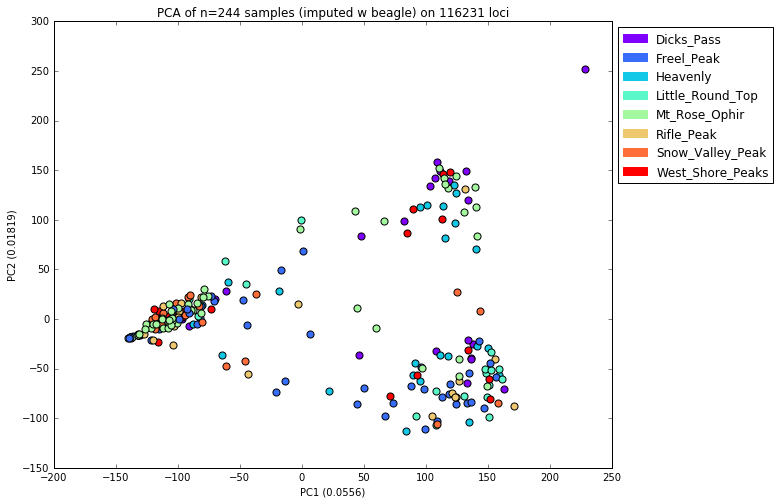

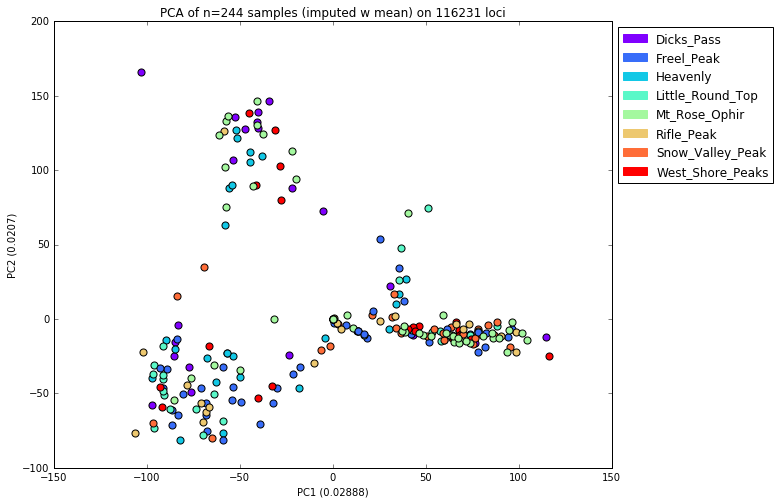

In [347]:
for key in pca_std.keys():
    plot_pca(key,pca_std[key],pca_std_data[key],pca_x[key],prcomp_res[key])

In [117]:
ntpDict[pop]

8

In [315]:
%%R
source("/home/lindb/g/ipython/tw_calc.R")
twtable=read.table("/home/lindb/g/ipython/twTable.txt", header=F)
tw_mis = TWcalc(as.matrix(data_mis),20)
tw_imp = TWcalc(as.matrix(data_imp),20)

In [316]:
tws = OrderedDict()
tws['mis'] = r("tw_mis[[2]]")
tws['imp'] = r("tw_imp[[2]]")

In [317]:
def get_sig_tracywidom(tw_p):
    ps = []
    for i, p in enumerate(tw_p):
        if p > 0.05:
            print(i, p)
            break
        else:
            ps.append(p)
    return len(ps), ps

In [318]:
#tw_num = [get_sig_tracywidom(x) for x in tws]
tw_num = OrderedDict()
for dset in tws.keys():
    tw_num[dset] = get_sig_tracywidom(tws[dset])

(3, 0.99940617499999995)
(4, 0.072872924000000006)


In [319]:
for dset in tw_num.keys():
    print dset,tw_num[dset]
#mis (3, [8.0000000000000005e-09, 8.0000000000000005e-09, 8.0000000000000005e-09])
#imp (4, [8.0000000000000005e-09, 8.0000000000000005e-09, 8.0000000000000005e-09, 8.0000000000000005e-09])

mis (3, [8.0000000000000005e-09, 8.0000000000000005e-09, 8.0000000000000005e-09])
imp (4, [8.0000000000000005e-09, 8.0000000000000005e-09, 8.0000000000000005e-09, 8.0000000000000005e-09])


### Tracy Widom
    imputed = 4
    missing = 3

In [320]:
tw_num

OrderedDict([('mis',
              (3,
               [8.0000000000000005e-09,
                8.0000000000000005e-09,
                8.0000000000000005e-09])),
             ('imp',
              (4,
               [8.0000000000000005e-09,
                8.0000000000000005e-09,
                8.0000000000000005e-09,
                8.0000000000000005e-09]))])

In [321]:
pca_std_data['imp']

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,-0.741698,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-0.502716,-0.454859,0.471605,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,0.561931
010compiled,-0.741698,1.942508,2.296415,-0.413449,-0.317554,-0.203489,-1.429456,-0.330868,-1.306753,-0.274147,...,-0.502716,-0.454859,-1.583246,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,-1.515511
011compiled,2.325665,-0.845562,2.296415,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-0.502716,-0.454859,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,-1.515511
012compiled,-0.741698,-0.845562,-0.748831,4.630630,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-0.502716,4.169539,2.526456,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,3.890070,0.561931
013compiled,5.393028,-0.845562,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,5.879271,0.877135,-0.274147,...,-0.502716,-0.454859,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,0.561931
014compiled,2.325665,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-0.502716,-0.454859,0.471605,-0.317554,-1.555973,-1.123145,-0.454859,-0.511868,-0.484018,-1.515511
015compiled,-0.741698,-0.845562,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-0.502716,-0.454859,-1.583246,-0.317554,-1.555973,1.219141,4.169539,-0.511868,3.890070,-1.515511
016compiled,-0.741698,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,3.727032,-0.454859,-1.583246,-0.317554,-1.555973,-1.123145,-0.454859,-0.511868,-0.484018,0.561931
017compiled,-0.741698,-0.845562,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,-1.306753,-0.274147,...,-0.502716,-0.454859,0.471605,-0.317554,-1.555973,-1.123145,-0.454859,-0.511868,-0.484018,-1.515511
018compiled,-0.741698,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-0.502716,-0.454859,0.471605,-0.317554,-1.555973,-1.123145,-0.454859,-0.511868,-0.484018,0.561931


In [322]:
pca_std['imp']

,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,NODE_1000180_length_98_cov_2.204082_17,NODE_1000188_length_67_cov_1.223881_65,...,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37,population,plot
009compiled,-0.741698,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,0.471605,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,0.561931,1,1
010compiled,-0.741698,1.942508,2.296415,-0.413449,-0.317554,-0.203489,-1.429456,-0.330868,-1.306753,-0.274147,...,-1.583246,-0.317554,0.507383,1.219141,-0.454859,-0.511868,-0.484018,-1.515511,1,1
011compiled,2.325665,-0.845562,2.296415,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,-1.515511,1,1
012compiled,-0.741698,-0.845562,-0.748831,4.630630,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,2.526456,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,3.890070,0.561931,1,1
013compiled,5.393028,-0.845562,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,5.879271,0.877135,-0.274147,...,0.471605,-0.317554,0.507383,-1.123145,-0.454859,-0.511868,-0.484018,0.561931,1,1
014compiled,2.325665,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,0.471605,-0.317554,-1.555973,-1.123145,-0.454859,-0.511868,-0.484018,-1.515511,1,1
015compiled,-0.741698,-0.845562,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-1.583246,-0.317554,-1.555973,1.219141,4.169539,-0.511868,3.890070,-1.515511,1,1
016compiled,-0.741698,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,-1.583246,-0.317554,-1.555973,-1.123145,-0.454859,-0.511868,-0.484018,0.561931,1,1
017compiled,-0.741698,-0.845562,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,-1.306753,-0.274147,...,0.471605,-0.317554,-1.555973,-1.123145,-0.454859,-0.511868,-0.484018,-1.515511,1,1
018compiled,-0.741698,1.942508,-0.748831,-0.413449,-0.317554,-0.203489,0.684406,-0.330868,0.877135,-0.274147,...,0.471605,-0.317554,-1.555973,-1.123145,-0.454859,-0.511868,-0.484018,0.561931,1,2


In [323]:
pca_x['imp']

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244
009compiled,-61.388551,28.149657,22.190595,-133.194194,48.989416,-43.432926,-1.275564,11.544678,-37.374060,32.496316,...,0.219103,-0.056206,0.005944,-0.085358,0.125850,-0.125695,0.074750,-0.189168,0.443855,-2.549343e-10
010compiled,134.436939,120.047971,74.076630,27.239096,62.674998,30.749613,-25.391792,-16.555259,-24.196016,-79.269959,...,-0.075476,-0.165673,0.143099,0.123116,-0.030984,0.052445,0.001233,0.004421,-0.163867,-2.549509e-10
011compiled,133.378767,-64.459323,15.539632,-11.652990,14.884596,55.826882,36.623025,77.487397,-51.650985,-42.660001,...,0.076649,0.305732,-0.079873,-0.024622,-0.053867,0.043298,-0.006808,-0.107455,-0.015652,-2.542708e-10
012compiled,228.558021,252.049578,349.834612,-81.098185,-523.422539,-68.488355,30.052452,61.889337,-50.248009,7.436572,...,0.112173,1.222823,0.080979,0.011848,-0.028699,0.137371,0.114205,0.041218,-0.232853,-2.547735e-10
013compiled,163.075633,-70.833285,110.215646,-2.940702,45.538754,3.491887,-109.321658,49.883963,53.107685,-76.225731,...,0.172720,0.034191,-0.075845,0.157035,-0.134959,0.286004,0.085511,-0.017980,-0.088510,-2.548820e-10
014compiled,108.334781,-32.495724,-70.288569,-28.907819,-13.399416,-47.614802,-62.324040,68.297290,23.699938,-0.532356,...,0.111343,0.013590,0.027815,0.024495,-0.076841,-0.099926,0.057760,-0.016322,-0.064401,-2.550013e-10
015compiled,103.680568,134.211415,-89.508758,0.940168,-22.964756,-22.690935,-15.389945,-32.303977,24.279629,-19.230628,...,-0.212011,-0.102566,0.126756,-0.035767,0.216655,0.053591,0.143457,0.053072,-0.192083,-2.541597e-10
016compiled,108.922078,158.074882,45.105935,60.186484,54.256982,-38.138285,-41.295210,-8.853306,20.858668,50.753305,...,-0.014528,-0.044941,-0.058330,0.125417,-0.153760,0.209951,-0.041148,0.078176,0.223957,-2.549239e-10
017compiled,-96.352609,-0.477517,28.005757,-10.341422,10.742600,-15.208633,-8.569519,5.400191,2.973898,-2.708435,...,0.454321,1.533480,-0.174839,-0.431000,0.697382,0.314079,-0.097773,-0.111077,-0.370595,-2.549104e-10
018compiled,107.279115,141.852311,-39.409508,31.999115,7.223353,-11.268492,64.133844,18.426310,17.050266,-7.722168,...,-0.010330,0.132424,-0.224672,0.140190,0.222414,-0.215710,-0.046976,-0.033953,-0.027361,-2.551045e-10


In [324]:
pca_x['mis']

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244
009compiled,114.421755,-12.391691,-33.089624,50.902123,14.069339,-7.475776,4.633196,-2.687994,0.102469,-3.319923,...,-0.086698,0.085828,-0.084992,0.073868,-0.064556,0.047501,-0.043322,0.033362,-0.027821,-2.351588e-10
010compiled,-53.440287,107.165989,81.620446,58.574652,-16.800845,1.682443,-77.919014,-18.554820,42.997075,-26.997676,...,-0.092404,0.085901,-0.083660,0.073607,-0.060622,0.048155,-0.043587,0.035071,-0.027765,-2.352179e-10
011compiled,-76.194604,-49.257661,6.870696,30.237362,-66.052783,0.136790,20.163517,-27.460540,64.365381,4.075259,...,-0.091560,0.083094,-0.081869,0.077328,-0.063307,0.047716,-0.043786,0.034992,-0.027572,-2.351688e-10
012compiled,-102.979198,165.751598,77.754290,158.189999,220.913864,-71.894986,280.611037,45.438808,159.673399,-116.186604,...,-0.094254,0.082257,-0.082633,0.073348,-0.063944,0.048706,-0.044131,0.034755,-0.027510,-2.352122e-10
013compiled,-96.968516,-57.703256,84.217008,60.882786,31.496117,-38.892504,-66.612663,-125.023235,24.581206,-15.935117,...,-0.094213,0.083785,-0.084480,0.072441,-0.060828,0.047380,-0.043953,0.034237,-0.027584,-2.351402e-10
014compiled,-57.009558,-22.561941,-63.070788,-29.660275,22.845081,-27.535695,3.027196,-76.293873,-0.458950,-18.080201,...,-0.091411,0.084775,-0.083563,0.072579,-0.061980,0.048632,-0.043869,0.034863,-0.027941,-2.352115e-10
015compiled,-40.424234,128.294001,-68.255104,-27.578338,31.938288,-12.719105,32.369769,38.513622,2.728292,65.622286,...,-0.095730,0.083017,-0.082835,0.075040,-0.061159,0.049143,-0.043522,0.033976,-0.027937,-2.352202e-10
016compiled,-34.448252,146.627193,72.617012,-12.753375,44.058380,-2.181890,-21.265585,-21.826787,-65.631855,-72.065860,...,-0.090174,0.083752,-0.080129,0.074793,-0.062700,0.047340,-0.043296,0.033527,-0.027516,-2.351700e-10
017compiled,67.715414,-13.820333,17.034756,-0.245067,7.598355,-2.008339,-0.861781,-8.005320,1.083061,3.360712,...,-0.091044,0.084504,-0.084313,0.072692,-0.060007,0.050204,-0.043313,0.033865,-0.027588,-2.351846e-10
018compiled,-40.704496,132.471695,-11.226072,-27.384161,-25.648492,38.931085,17.675865,-23.069504,18.639714,-17.397724,...,-0.093753,0.084643,-0.086140,0.077859,-0.061887,0.051748,-0.042596,0.034115,-0.027865,-2.351553e-10


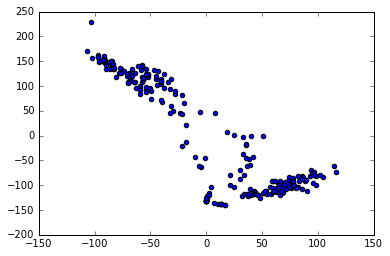

In [326]:
plt.scatter(pca_x['mis']['PC1'],pca_x['imp']['PC1'])

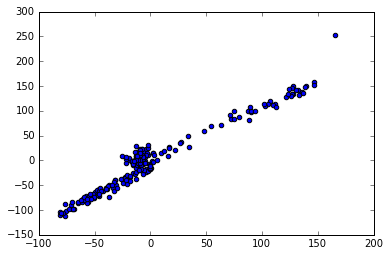

In [327]:
plt.scatter(pca_x['mis']['PC2'],pca_x['imp']['PC2'])

In [329]:
from scipy.stats import spearmanr

In [330]:
spearmanr(pca_x['imp']['PC1'],pca_x['mis']['PC1'])

SpearmanrResult(correlation=-0.76385925347673977, pvalue=6.3259666309127051e-48)

In [331]:
#figure out amount of missing data per individual across snps
misDict = OrderedDict()
df = hierf_z12['mis']
for samp in df.index:
    data = df.loc[samp,:]
    missingdata = data.tolist().count(-1)
    pmissing = missingdata/len(data)
    misDict[samp] = pmissing

In [332]:
len(misDict.keys())

244

In [333]:
misDict['009compiled']

0.22842910361085061

In [334]:
max(misDict.values())

0.9994579852537575

In [335]:
for samp in misDict.keys():
    print samp, misDict[samp]

009compiled 0.228429103611
010compiled 0.0161916151179
011compiled 0.0743850713653
012compiled 0.00190135331618
013compiled 0.0414684297919
014compiled 0.0696187829618
015compiled 0.0356181118959
016compiled 0.0224462932214
017compiled 0.494549740607
018compiled 0.029010694037
019compiled 0.125893679076
020compiled 0.508229160393
021compiled 0.0467595261243
022compiled 0.026137155541
023compiled 0.571464214122
024compiled 0.0462605284214
025compiled 0.0405134514295
026compiled 0.661344024503
027compiled 0.0267738077826
028compiled 0.203745924135
029compiled 0.017077766211
030compiled 0.0613250970034
031compiled 0.0702640386121
032compiled 0.535897722678
033compiled 0.478211867542
034compiled 0.0291483485757
035compiled 0.528533204856
036compiled 0.680598453107
037compiled 0.115440537541
038compiled 0.0202266137844
039compiled 0.129154370962
040compiled 0.0700747636213
041compiled 0.415406984247
042compiled 0.288704584756
043compiled 0.032718763174
044compiled 0.0555350029682
045compile

In [336]:
pd.DataFrame([float(x) for x in misDict.values()]).describe()

,0
count,244.000000
mean,0.350265
std,0.302616
min,0.001901
25%,0.059060
50%,0.327059
75%,0.558295
max,0.999458


(array([ 86.,  21.,  11.,  18.,  28.,  31.,  17.,  10.,   2.,  20.]),
 array([ 0.00190135,  0.10165702,  0.20141268,  0.30116834,  0.40092401,
         0.50067967,  0.60043533,  0.700191  ,  0.79994666,  0.89970232,
         0.99945799]),
 <a list of 10 Patch objects>)

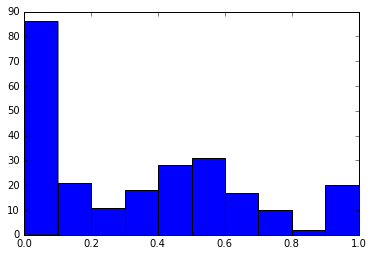

In [337]:
plt.hist([float(x) for x in misDict.values()])

In [338]:
misDict.keys() == pca_x['imp'].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [339]:
misDict.keys() == pca_x['mis'].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [340]:
color = misDict.values()

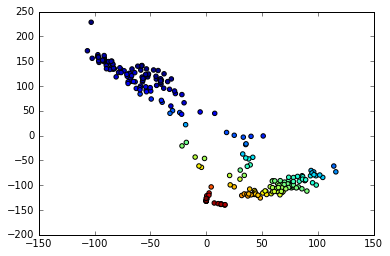

In [342]:
plt.scatter(pca_x['mis']['PC1'],pca_x['imp']['PC1'],c=color)

In [344]:
popcols = []
for samp in pca_x['imp'].index:
    popcols.append(popids[stpDict[samp]['pop']])

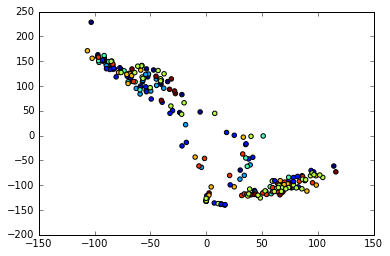

In [345]:
plt.scatter(pca_x['mis']['PC1'],pca_x['imp']['PC1'],c=popcols)